# Data mining project

Objective : The objective of this notebook is to create an availability forecasting model of bikes and docks in a biking sharing station ahead of time in october 2020.




## Import the data and packages





In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_mining/part2/Projet_Data_mining/202009-citibike-tripdata.csv')
#df = pd.read_csv('/content/drive/MyDrive/202009-citibike-tripdata.csv')

## Data preparation





In [ ]:
df.head()

In [ ]:
df.info()

After an initial analysis, I identified a problem with the dataset in New York City (NYC). The city regularly relocates bikes from less-used stations to meet demand elsewhere. Unfortunately, these movements are not recorded.

This issue creates a challenge: when examining a station with low bike usage, the city likely transfers bikes from there to fulfill demand in other stations.

Consequently, the estimated number of available bikes can either continually decrease (as the city adds bikes to low-usage stations that are frequently used but not returned) or increase indefinitely (if more people bring bikes than those taking them, prompting the city to relocate bikes to meet demand).

To address this, a reliable estimation of the available bikes over time should resemble a curve bounded by the station's maximum docking capacity and zero.

To begin, let's focus on detecting the relocated bikes in the dataset.

## Detect relocated bike

In [ ]:
dfbike=df.sort_values(by=['bikeid','starttime'])
dfbike.head(10)

When we track the path of a bike (using its bike ID), we observe that the ending station ID matches the subsequent starting station ID. This suggests that someone initially brought the bike to a station, and later, another person picked it up from there to travel elsewhere.

Consequently, if a bike's ID shows it ending at one station and starting at another, it raises the suspicion that the city may have relocated the bike.

In [ ]:
offset = pd.DataFrame({'starttime': pd.to_datetime('2010-09-01'),\
  'start station id':0,'stoptime': pd.to_datetime('2010-09-01'),\
  'end station id':0,'bikeid':0},index=[0])

In [ ]:
dfbike1 = pd.concat([offset,dfbike]).reset_index(drop=True)
dfbike2 = pd.concat([dfbike,offset]).reset_index(drop=True)

In [ ]:
dfbike=pd.concat ([dfbike1[['bikeid','stoptime','end station id']]\
            ,dfbike2[['bikeid','starttime','start station id']] ],\
             axis=1 )
dfbike.head()

From this dataset it is easier to detect when we have relocated bikes. We just need to compare line by line that we have the same ending and starting station id.

In [ ]:
dfbike.columns=['bikeid1','starttime','start station id',
                'bikeid2','stoptime','end station id']
dfbike

In [ ]:
dfrebal = dfbike[['starttime','start station id','stoptime','end station id']].loc[(dfbike.bikeid1==dfbike.bikeid2) & (dfbike['start station id'] != dfbike['end station id']) ]
dfrebal.reset_index(drop=True, inplace=True)
dfrebal

This is the dataset of the bikes that has been moved. We can add those movement to the initial dataset to do our analysis.

In [ ]:
df = pd.concat([df,dfrebal])
df.reset_index(drop=True, inplace=True)

Save the dataset

In [ ]:
df.to_csv('/content/drive/MyDrive/Data_mining/part2/Projet_Data_mining/Final_db.csv', index=False)
#df.to_csv('/content/drive/MyDrive/Final_db.csv', index=False)

## Estimation of the number of bike in the stations

New initialization here :

In [ ]:
# We get the preprocessed data :
df = pd.read_csv('/content/drive/MyDrive/Data_mining/part2/Projet_Data_mining/Final_db.csv')
#df = pd.read_csv('/content/drive/MyDrive/Final_db.csv')

<ipython-input-18-b2a597917e09>:2: DtypeWarning: Columns (4,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Data_mining/part2/Projet_Data_mining/Final_db.csv')


We first keep the only relevant variables to achieve our goal.

We remove tripduration, station name, bikeid, usertype, birth year,gender because this is not relevant informations.

In [ ]:
df=df[["starttime","stoptime","start station id","end station id","start station latitude","start station longitude","end station latitude","end station longitude"]]
df.reset_index(drop=True, inplace=True)
df

,starttime,stoptime,start station id,end station id,start station latitude,start station longitude,end station latitude,end station longitude
0,2020-09-01 00:00:01.0430,2020-09-01 01:10:26.6350,3508,116,40.809725,-73.953149,40.741776,-74.001497
1,2020-09-01 00:00:04.8320,2020-09-01 00:31:13.7650,3621,3094,40.773983,-73.930913,40.716981,-73.944859
2,2020-09-01 00:00:06.8990,2020-09-01 00:18:24.2260,3492,3959,40.800539,-73.941995,40.823498,-73.943860
3,2020-09-01 00:00:07.7440,2020-09-01 00:24:41.1800,3946,4002,40.818477,-73.947568,40.820877,-73.939249
4,2020-09-01 00:00:12.2020,2020-09-01 00:20:05.5470,3081,3048,40.711863,-73.944024,40.684020,-73.949770
...,...,...,...,...,...,...,...,...
2527780,2020-09-29 23:29:07.8720,2020-09-30 22:48:23.8860,247,349,NaN,NaN,NaN,NaN
2527781,2020-09-30 15:35:33.6610,2020-09-30 22:44:19.1910,385,440,NaN,NaN,NaN,NaN
2527782,2020-09-30 15:07:02.7290,2020-09-30 15:35:09.0010,515,480,NaN,NaN,NaN,NaN
2527783,2020-09-30 07:17:07.8240,2020-09-30 08:35:58.4240,3256,3664,NaN,NaN,NaN,NaN


We add a one for the bikes entering a station, we remove one when one is leaving.

In [ ]:
df_leave = df[["starttime","start station id","start station latitude","start station longitude"]].assign(act=-1)
df_arrive = df[["stoptime","end station id","end station latitude","end station longitude"]].assign(act=1)

In [ ]:
df_leave.columns = ['docktime','stationid','lat','long','action']
df_arrive.columns = ['docktime','stationid','lat','long','action']
df = pd.concat([df_leave,df_arrive])

We convert the temporal variables in date time format.

In [ ]:
df['docktime']= pd.to_datetime(df['docktime'])
df['day'] = df['docktime'].dt.day_name()
df['time'] = df['docktime'].dt.strftime('%H:%M:%S')

We create a categorical variable for the time. This will be way simpler to handle than continuous time.

In [ ]:
df['hour'] = df['docktime'].dt.hour

intervals = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12),
              (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23)]
interval_labels = [f'{start:02d}:00 - {end:02d}:59' for start, end in intervals]
df['hour_interval'] = pd.cut(df['hour'], bins=[start-0.5 for start, end in intervals] + [23.5], labels=interval_labels)

df = df.drop(columns=['hour'])

In [ ]:
df.describe()

,stationid,lat,long,action
count,5.055570e+06,4.976450e+06,4.976450e+06,5055570.0
mean,2.106927e+03,4.074105e+01,-7.397657e+01,0.0
std,1.554365e+03,3.606739e-02,2.372347e-02,1.0
min,7.200000e+01,4.065540e+01,-7.407126e+01,-1.0
25%,4.270000e+02,4.071689e+01,-7.399393e+01,-1.0
50%,3.112000e+03,4.073936e+01,-7.398142e+01,0.0
75%,3.523000e+03,4.076440e+01,-7.395962e+01,1.0
max,4.202000e+03,4.085225e+01,-7.388827e+01,1.0


### Analysis of one specific station :

Analyse all the stations is a bit complicated. The idea here is simplify the problem first. First, we extract the evolution of the number of bike available in a specific station. Then, we create a function to do it for any station.

In [ ]:
df_station = df.loc[(df.stationid==379) ].\
  drop_duplicates()
df_station.sort_values(by=['docktime'], inplace=True)
df_station.reset_index(drop=True, inplace=True)


In [ ]:
df_station.head(10)

,docktime,stationid,lat,long,action,day,time,hour_interval
0,2020-09-01 00:42:43.779,379,40.749156,-73.9916,1,Tuesday,00:42:43,00:00 - 00:59
1,2020-09-01 01:17:12.448,379,40.749156,-73.9916,1,Tuesday,01:17:12,01:00 - 01:59
2,2020-09-01 04:42:54.568,379,40.749156,-73.9916,1,Tuesday,04:42:54,04:00 - 04:59
3,2020-09-01 05:17:08.670,379,40.749156,-73.9916,-1,Tuesday,05:17:08,05:00 - 05:59
4,2020-09-01 05:37:29.281,379,40.749156,-73.9916,1,Tuesday,05:37:29,05:00 - 05:59
5,2020-09-01 06:03:24.066,379,40.749156,-73.9916,1,Tuesday,06:03:24,06:00 - 06:59
6,2020-09-01 06:08:22.417,379,40.749156,-73.9916,-1,Tuesday,06:08:22,06:00 - 06:59
7,2020-09-01 06:09:02.870,379,40.749156,-73.9916,1,Tuesday,06:09:02,06:00 - 06:59
8,2020-09-01 06:10:53.029,379,40.749156,-73.9916,-1,Tuesday,06:10:53,06:00 - 06:59
9,2020-09-01 06:16:38.907,379,40.749156,-73.9916,-1,Tuesday,06:16:38,06:00 - 06:59


We cumulate the +1 and -1 in the station 379 over the time. This is our first estimate of the count of bike in the station.

In [ ]:
df_station = df_station.assign(cnt =df_station.action.cumsum())
df_station

,docktime,stationid,lat,long,action,day,time,hour_interval,cnt
0,2020-09-01 00:42:43.779,379,40.749156,-73.9916,1,Tuesday,00:42:43,00:00 - 00:59,1
1,2020-09-01 01:17:12.448,379,40.749156,-73.9916,1,Tuesday,01:17:12,01:00 - 01:59,2
2,2020-09-01 04:42:54.568,379,40.749156,-73.9916,1,Tuesday,04:42:54,04:00 - 04:59,3
3,2020-09-01 05:17:08.670,379,40.749156,-73.9916,-1,Tuesday,05:17:08,05:00 - 05:59,2
4,2020-09-01 05:37:29.281,379,40.749156,-73.9916,1,Tuesday,05:37:29,05:00 - 05:59,3
...,...,...,...,...,...,...,...,...,...
10901,2020-09-30 23:21:10.177,379,40.749156,-73.9916,-1,Wednesday,23:21:10,23:00 - 23:59,14
10902,2020-09-30 23:32:34.488,379,40.749156,-73.9916,1,Wednesday,23:32:34,23:00 - 23:59,15
10903,2020-09-30 23:40:13.442,379,40.749156,-73.9916,1,Wednesday,23:40:13,23:00 - 23:59,16
10904,2020-09-30 23:42:01.678,379,40.749156,-73.9916,1,Wednesday,23:42:01,23:00 - 23:59,17


As we start our analysis with the assumption of having zero bike in the station (likely incorrect), the count may become negative, which is not possible. To address this, we estimate the initial number of bikes by adding the minimum value reached in the series.

In [ ]:
df_station['cnt']=df_station['cnt']+abs(df_station.cnt.min())

Let's see how the serie looks like :

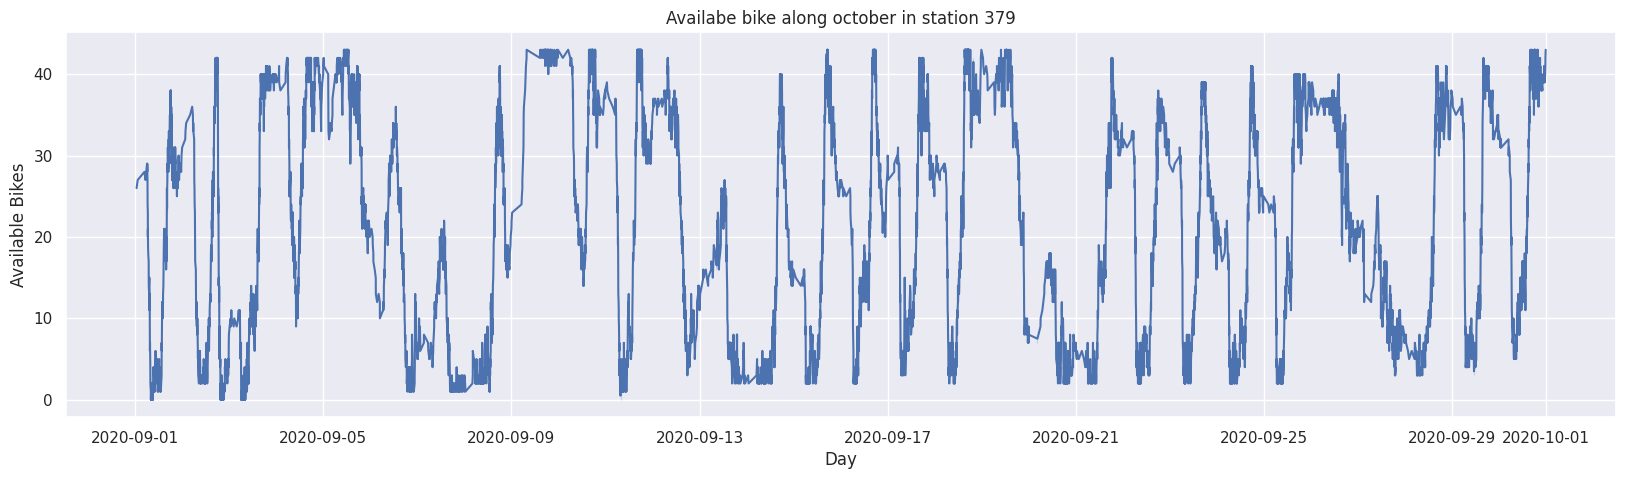

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(20,5))
ax=sns.lineplot(data=df_station , x='docktime', y='cnt' )
ax.set_xlabel('Day')
ax.set_ylabel('Available Bikes')
plt.title("Availabe bike along october in station 379");

The serie looks great and make perfectly sense.

### Complete the information with weather data

It makes sense to think that the use of bike in a city depends a lot on weather factors such as temperature, if it's raining, and so on. Thus, we decide to introduce a weather dataset to our analysis.

The dataset is a record of weather data in New York in september 2020. Thanks to this dataset we have access to many factors like temperature, felt temperature, humidity, weather conditions etc.

In [ ]:
df_weather=pd.read_csv('/content/drive/MyDrive/Data_mining/part2/Projet_Data_mining/weather-2020-09.csv')
#df_weather=pd.read_csv('/content/drive/MyDrive/weather-2020-09.csv')

In [ ]:
df_weather.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,weather in New york,2020-09-01T00:00:00,22.6,22.6,16.8,69.53,0.000,0,NaN,0,...,1019.4,50.4,16.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"KEWR,72055399999,72502014734,72058100178,KJRB,..."
1,weather in New york,2020-09-01T01:00:00,22.6,22.6,18.0,75.38,0.000,0,NaN,0,...,1019.1,17.7,16.0,0.0,0.0,0,NaN,Clear,clear-night,"KEWR,72055399999,72502014734,72058100178,KJRB,..."
2,weather in New york,2020-09-01T02:00:00,22.0,22.0,18.9,82.33,0.074,100,rain,0,...,1019.1,70.1,16.0,0.0,0.0,0,NaN,"Rain, Partially cloudy",rain,"KEWR,72055399999,72502014734,72058100178,KJRB,..."
3,weather in New york,2020-09-01T03:00:00,21.5,21.5,18.4,82.77,0.074,100,rain,0,...,1019.0,70.2,16.0,0.0,0.0,0,NaN,"Rain, Partially cloudy",rain,"KEWR,72055399999,72502014734,72058100178,KJRB,..."
4,weather in New york,2020-09-01T04:00:00,20.7,20.7,18.3,86.22,0.174,100,rain,0,...,1018.9,71.0,16.0,0.0,0.0,0,NaN,"Rain, Partially cloudy",rain,"KEWR,72055399999,72502014734,72058100178,KJRB,..."


In [ ]:
# We convert the format to date time
df_weather['datetime']=pd.to_datetime(df_weather['datetime'])
df_weather['Station_name']=df_weather['stations'].str.split(',').str.get(0)

We keep the weather station data as close as possible of Manhattan since most of the bike stations are located there.

In [ ]:
df_weather=df_weather[df_weather.Station_name=="KEWR"] #KEWR is the name of the closest weather station to central NYC.
df_weather['rounded_hour']=df_weather['datetime'].dt.hour
df_weather['date']=df_weather['datetime'].dt.date

<ipython-input-34-a553879ae05f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['rounded_hour']=df_weather['datetime'].dt.hour
<ipython-input-34-a553879ae05f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['date']=df_weather['datetime'].dt.date


In [ ]:
df_station['rounded_hour']=df_station['docktime'].dt.hour
df_station['date']=df_station['docktime'].dt.date

In [ ]:
df_station

,docktime,stationid,lat,long,action,day,time,hour_interval,cnt,rounded_hour,date
0,2020-09-01 00:42:43.779,379,40.749156,-73.9916,1,Tuesday,00:42:43,00:00 - 00:59,26,0,2020-09-01
1,2020-09-01 01:17:12.448,379,40.749156,-73.9916,1,Tuesday,01:17:12,01:00 - 01:59,27,1,2020-09-01
2,2020-09-01 04:42:54.568,379,40.749156,-73.9916,1,Tuesday,04:42:54,04:00 - 04:59,28,4,2020-09-01
3,2020-09-01 05:17:08.670,379,40.749156,-73.9916,-1,Tuesday,05:17:08,05:00 - 05:59,27,5,2020-09-01
4,2020-09-01 05:37:29.281,379,40.749156,-73.9916,1,Tuesday,05:37:29,05:00 - 05:59,28,5,2020-09-01
...,...,...,...,...,...,...,...,...,...,...,...
10901,2020-09-30 23:21:10.177,379,40.749156,-73.9916,-1,Wednesday,23:21:10,23:00 - 23:59,39,23,2020-09-30
10902,2020-09-30 23:32:34.488,379,40.749156,-73.9916,1,Wednesday,23:32:34,23:00 - 23:59,40,23,2020-09-30
10903,2020-09-30 23:40:13.442,379,40.749156,-73.9916,1,Wednesday,23:40:13,23:00 - 23:59,41,23,2020-09-30
10904,2020-09-30 23:42:01.678,379,40.749156,-73.9916,1,Wednesday,23:42:01,23:00 - 23:59,42,23,2020-09-30


Now we want to join the bike station data with weather data.

In [ ]:
df_station = pd.merge(df_station, df_weather,left_on=['date','rounded_hour'], right_on=['date','rounded_hour'], how='inner')


In [ ]:
df_station.head()

,docktime,stationid,lat,long,action,day,time,hour_interval,cnt,rounded_hour,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations,Station_name
0,2020-09-01 00:42:43.779,379,40.749156,-73.9916,1,Tuesday,00:42:43,00:00 - 00:59,26,0,...,50.4,16.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"KEWR,72055399999,72502014734,72058100178,KJRB,...",KEWR
1,2020-09-01 01:17:12.448,379,40.749156,-73.9916,1,Tuesday,01:17:12,01:00 - 01:59,27,1,...,17.7,16.0,0.0,0.0,0,NaN,Clear,clear-night,"KEWR,72055399999,72502014734,72058100178,KJRB,...",KEWR
2,2020-09-01 04:42:54.568,379,40.749156,-73.9916,1,Tuesday,04:42:54,04:00 - 04:59,28,4,...,71.0,16.0,0.0,0.0,0,NaN,"Rain, Partially cloudy",rain,"KEWR,72055399999,72502014734,72058100178,KJRB,...",KEWR
3,2020-09-01 05:17:08.670,379,40.749156,-73.9916,-1,Tuesday,05:17:08,05:00 - 05:59,27,5,...,76.7,13.5,0.0,0.0,0,NaN,"Rain, Partially cloudy",rain,"KEWR,72055399999,72502014734,72058100178,KJRB,...",KEWR
4,2020-09-01 05:37:29.281,379,40.749156,-73.9916,1,Tuesday,05:37:29,05:00 - 05:59,28,5,...,76.7,13.5,0.0,0.0,0,NaN,"Rain, Partially cloudy",rain,"KEWR,72055399999,72502014734,72058100178,KJRB,...",KEWR


In [ ]:
df_station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10736 entries, 0 to 10735
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   docktime          10736 non-null  datetime64[ns]
 1   stationid         10736 non-null  int64         
 2   lat               10679 non-null  float64       
 3   long              10679 non-null  float64       
 4   action            10736 non-null  int64         
 5   day               10736 non-null  object        
 6   time              10736 non-null  object        
 7   hour_interval     10736 non-null  category      
 8   cnt               10736 non-null  int64         
 9   rounded_hour      10736 non-null  int64         
 10  date              10736 non-null  object        
 11  name              10736 non-null  object        
 12  datetime          10736 non-null  datetime64[ns]
 13  temp              10736 non-null  float64       
 14  feelslike         1073

We keep only the variable we are interested in.


In [ ]:
df_station=df_station.drop(['lat','long','action','rounded_hour','date','name','datetime','stations','Station_name'],axis=1)

In [ ]:
df_station.head()

,docktime,stationid,day,time,hour_interval,cnt,temp,feelslike,dew,humidity,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon
0,2020-09-01 00:42:43.779,379,Tuesday,00:42:43,00:00 - 00:59,26,22.6,22.6,16.8,69.53,...,130.0,1019.4,50.4,16.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night
1,2020-09-01 01:17:12.448,379,Tuesday,01:17:12,01:00 - 01:59,27,22.6,22.6,18.0,75.38,...,143.0,1019.1,17.7,16.0,0.0,0.0,0,NaN,Clear,clear-night
2,2020-09-01 04:42:54.568,379,Tuesday,04:42:54,04:00 - 04:59,28,20.7,20.7,18.3,86.22,...,92.0,1018.9,71.0,16.0,0.0,0.0,0,NaN,"Rain, Partially cloudy",rain
3,2020-09-01 05:17:08.670,379,Tuesday,05:17:08,05:00 - 05:59,27,20.1,20.1,18.3,89.47,...,111.0,1019.4,76.7,13.5,0.0,0.0,0,NaN,"Rain, Partially cloudy",rain
4,2020-09-01 05:37:29.281,379,Tuesday,05:37:29,05:00 - 05:59,28,20.1,20.1,18.3,89.47,...,111.0,1019.4,76.7,13.5,0.0,0.0,0,NaN,"Rain, Partially cloudy",rain


Let's create a function that takes as input the full df_station dataset and the station id in order to get as output a clean dataset by station. This is a way to formalize what we did previously in order to generalize the process to the whole dataset.

In [ ]:
def process_station_data(df, station_id, weather_file_path):

    df_station = df.loc[df['stationid'] == station_id].drop_duplicates()

    # Sort values by 'docktime', reset index
    df_station.sort_values(by=['docktime'], inplace=True)
    df_station.reset_index(drop=True, inplace=True)

    # Calculate cumulative sum of 'action' as 'cnt'
    df_station = df_station.assign(cnt=df_station['action'].cumsum())
    df_station['cnt'] = df_station['cnt'] + abs(df_station['cnt'].min())

    # Read weather data from the specified file path
    df_weather = pd.read_csv(weather_file_path)
    df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
    df_weather['Station_name'] = df_weather['stations'].str.split(',').str.get(0)

    # Filter weather data for the specified station_id
    df_weather = df_weather[df_weather['Station_name'] == "KEWR"]

    # Extract hour and date information
    df_weather['rounded_hour'] = df_weather['datetime'].dt.hour
    df_weather['date'] = df_weather['datetime'].dt.date

    # Extract hour and date information for df_station
    df_station['rounded_hour'] = df_station['docktime'].dt.hour
    df_station['date'] = df_station['docktime'].dt.date

    # Merge df_station with df_weather on 'date' and 'rounded_hour'
    df_station = pd.merge(df_station, df_weather, left_on=['date', 'rounded_hour'], right_on=['date', 'rounded_hour'], how='inner')

    # Drop unnecessary columns
    df_station = df_station.drop(['lat', 'long', 'action', 'rounded_hour', 'date', 'name', 'datetime', 'stations', 'Station_name'], axis=1)
    return df_station


In [ ]:
df['stationid']=df['stationid'].astype(str)

In [ ]:
station_id = "426"
weather_file_path = '/content/drive/MyDrive/Data_mining/part2/Projet_Data_mining/weather-2020-09.csv'
df_station = process_station_data(df, station_id, weather_file_path)
df_station

,docktime,stationid,day,time,hour_interval,cnt,temp,feelslike,dew,humidity,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon
0,2020-09-01 00:03:24.273,426,Tuesday,00:03:24,00:00 - 00:59,12,22.6,22.6,16.8,69.53,...,130.0,1019.4,50.4,16.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night
1,2020-09-01 00:37:49.965,426,Tuesday,00:37:49,00:00 - 00:59,11,22.6,22.6,16.8,69.53,...,130.0,1019.4,50.4,16.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night
2,2020-09-01 01:12:54.938,426,Tuesday,01:12:54,01:00 - 01:59,12,22.6,22.6,18.0,75.38,...,143.0,1019.1,17.7,16.0,0.0,0.0,0,NaN,Clear,clear-night
3,2020-09-01 05:59:19.043,426,Tuesday,05:59:19,05:00 - 05:59,13,20.1,20.1,18.3,89.47,...,111.0,1019.4,76.7,13.5,0.0,0.0,0,NaN,"Rain, Partially cloudy",rain
4,2020-09-01 06:42:24.308,426,Tuesday,06:42:24,06:00 - 06:59,12,20.3,20.3,18.2,87.62,...,72.0,1019.6,78.9,14.2,5.7,0.0,0,NaN,"Rain, Partially cloudy",rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26833,2020-09-30 23:38:38.219,426,Wednesday,23:38:38,23:00 - 23:59,50,17.1,17.1,10.0,62.89,...,208.0,1011.5,0.0,16.0,0.0,0.0,0,NaN,Clear,clear-night
26834,2020-09-30 23:38:59.744,426,Wednesday,23:38:59,23:00 - 23:59,51,17.1,17.1,10.0,62.89,...,208.0,1011.5,0.0,16.0,0.0,0.0,0,NaN,Clear,clear-night
26835,2020-09-30 23:42:05.432,426,Wednesday,23:42:05,23:00 - 23:59,50,17.1,17.1,10.0,62.89,...,208.0,1011.5,0.0,16.0,0.0,0.0,0,NaN,Clear,clear-night
26836,2020-09-30 23:59:25.042,426,Wednesday,23:59:25,23:00 - 23:59,51,17.1,17.1,10.0,62.89,...,208.0,1011.5,0.0,16.0,0.0,0.0,0,NaN,Clear,clear-night


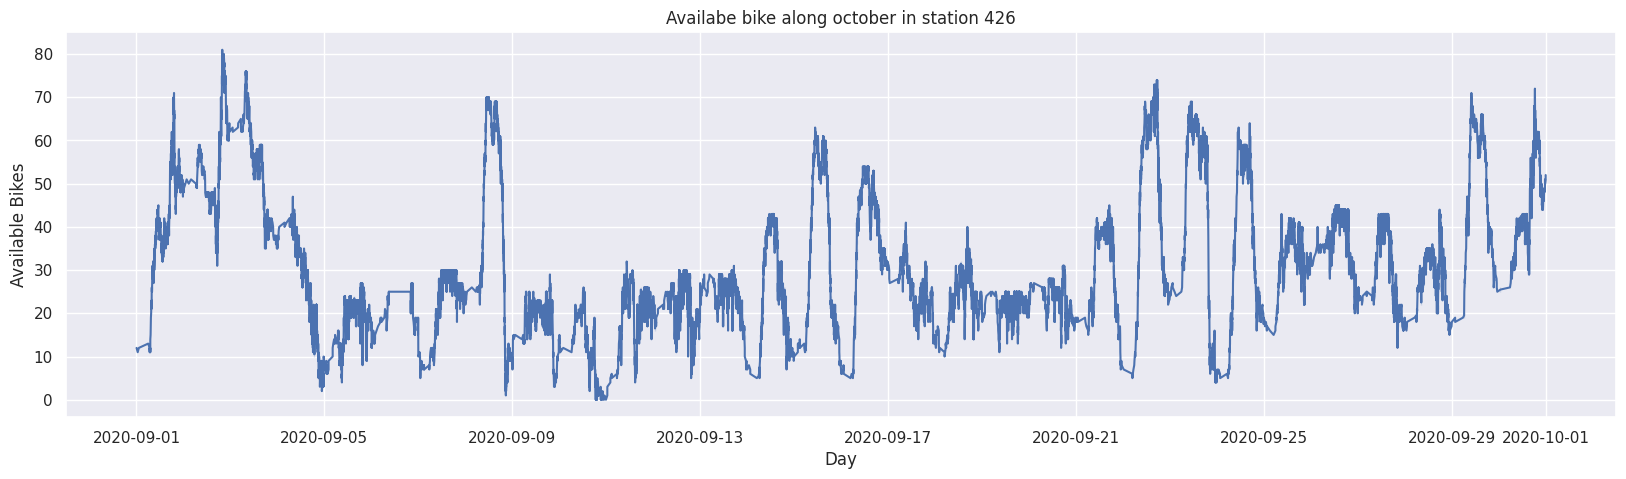

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(20,5))
ax=sns.lineplot(data=df_station , x='docktime', y='cnt' )
ax.set_xlabel('Day')
ax.set_ylabel('Available Bikes')
plt.title("Availabe bike along october in station 426");

Let's see how many stations we have to take care of :

In [ ]:
pd.unique(df['stationid']).shape

(1112,)

We have 1112 stations to concatenate. Lets keep only the one with enough observations:

In [ ]:
df['stationid'].value_counts().describe()

count     1112.000000
mean      4546.375899
std       4627.307146
min          1.000000
25%       1146.000000
50%       2908.000000
75%       6657.250000
max      28054.000000
Name: stationid, dtype: float64

<Axes: >

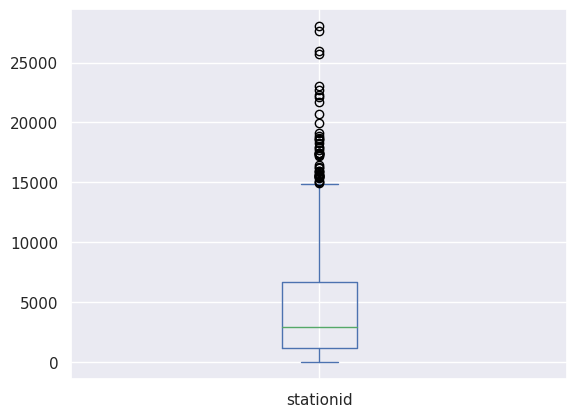

In [ ]:
df['stationid'].value_counts().plot(kind='box')

In [ ]:
df['stationid'].value_counts().index[df['stationid'].value_counts()>100]

Index(['435', '426', '514', '3141', '497', '358', '499', '3256', '3906',
       '3711',
       ...
       '4050', '4031', '4199', '4101', '4155', '4174', '4141', '4078', '4133',
       '4064'],
      dtype='object', length=1070)

In [ ]:
df=df[df['stationid'].isin(df['stationid'].value_counts().index[df['stationid'].value_counts()>100])]

After cleaning we have 1070 stations.

In [ ]:
df['stationid'].value_counts().describe()

count     1070.000000
mean      4724.167290
std       4627.689889
min        111.000000
25%       1296.500000
50%       2995.500000
75%       6783.250000
max      28054.000000
Name: stationid, dtype: float64

In [ ]:
pd.unique(df['stationid'])

array(['3508', '3621', '3492', ..., '389', '471', '72'], dtype=object)

Lets get the df_station for each stations and concatenate everything.

In [ ]:
weather_file_path = '/content/drive/MyDrive/Data_mining/part2/Projet_Data_mining/weather-2020-09.csv'
#weather_file_path = '/content/drive/MyDrive/weather-2020-09.csv'
df=df
df_station = process_station_data(df, '3508', weather_file_path)
for i in pd.unique(df['stationid'])[1:] :
  #print(i)
  df_station2 = process_station_data(df, i, weather_file_path)
  df_station=pd.concat([df_station,df_station2])

df = df_station

We clean the dataset :

In [ ]:
df.describe()

,stationid,month,cnt,temp,feelslike,dew,humidity,precip,precipprob,snow,...,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk
count,4.921343e+06,4921343.0,4.921343e+06,4.921343e+06,4.921343e+06,4.921343e+06,4.921343e+06,4.921343e+06,4.921343e+06,4921343.0,...,1.488259e+06,4.921343e+06,4.921343e+06,4.921343e+06,4.921343e+06,4.921343e+06,4.921343e+06,4.921343e+06,4.921343e+06,0.0
mean,2.105471e+03,9.0,1.898723e+01,2.210335e+01,2.217402e+01,1.286234e+01,5.862349e+01,5.086210e-02,5.787892e+00,0.0,...,3.694342e+01,1.285451e+01,1.600226e+02,1.018802e+03,4.958497e+01,1.577773e+01,2.589384e+02,9.339593e-01,2.584847e+00,NaN
std,1.554603e+03,0.0,1.521686e+01,3.980168e+00,4.134132e+00,6.592133e+00,1.852513e+01,4.099207e-01,2.335144e+01,0.0,...,1.112540e+01,5.803404e+00,1.046060e+02,6.485296e+00,2.444346e+01,1.053966e+00,2.537174e+02,9.126940e-01,2.572282e+00,NaN
min,7.200000e+01,9.0,0.000000e+00,8.900000e+00,7.000000e+00,-2.700000e+00,2.153000e+01,0.000000e+00,0.000000e+00,0.0,...,2.590000e+01,0.000000e+00,0.000000e+00,9.984000e+02,0.000000e+00,5.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,4.320000e+02,9.0,8.000000e+00,1.950000e+01,1.950000e+01,9.400000e+00,4.341000e+01,0.000000e+00,0.000000e+00,0.0,...,2.950000e+01,9.000000e+00,5.800000e+01,1.013800e+03,2.900000e+01,1.600000e+01,2.400000e+01,1.000000e-01,0.000000e+00,NaN
50%,3.112000e+03,9.0,1.600000e+01,2.270000e+01,2.270000e+01,1.430000e+01,5.943000e+01,0.000000e+00,0.000000e+00,0.0,...,3.350000e+01,1.200000e+01,1.500000e+02,1.018900e+03,5.050000e+01,1.600000e+01,1.880000e+02,7.000000e-01,2.000000e+00,NaN
75%,3.523000e+03,9.0,2.600000e+01,2.460000e+01,2.460000e+01,1.810000e+01,7.224000e+01,0.000000e+00,0.000000e+00,0.0,...,4.030000e+01,1.650000e+01,2.460000e+02,1.022800e+03,6.940000e+01,1.600000e+01,4.500000e+02,1.600000e+00,5.000000e+00,NaN
max,4.199000e+03,9.0,1.720000e+02,3.090000e+01,3.170000e+01,2.360000e+01,9.786000e+01,8.998000e+00,1.000000e+02,0.0,...,7.960000e+01,3.340000e+01,3.600000e+02,1.035500e+03,1.000000e+02,1.600000e+01,8.220000e+02,3.000000e+00,8.000000e+00,NaN


In [ ]:
categorical_columns = df.select_dtypes(exclude=['number']).columns

for column in categorical_columns:
    print(f"Column: {column}")
    print(df[column].value_counts())
    print("\n" + "="*50 + "\n")

Column: docktime
2020-09-17 18:34:33.277    4
2020-09-25 10:20:38.585    4
2020-09-10 18:23:00.850    3
2020-09-14 18:06:57.775    3
2020-09-22 14:48:15.765    3
                          ..
2020-09-18 15:17:52.588    1
2020-09-18 15:16:40.222    1
2020-09-18 15:16:27.308    1
2020-09-18 15:16:09.398    1
2020-09-30 23:54:16.213    1
Name: docktime, Length: 4836962, dtype: int64


Column: day
Wednesday    848170
Tuesday      777574
Saturday     771685
Friday       735448
Monday       637742
Thursday     607445
Sunday       543279
Name: day, dtype: int64


Column: time
18:25:31    187
17:47:53    185
18:17:58    183
18:24:08    181
18:22:20    179
           ... 
04:26:14      1
03:45:25      1
04:05:00      1
04:54:34      1
04:39:45      1
Name: time, Length: 85861, dtype: int64


Column: hour_interval
18:00 - 18:59    497137
17:00 - 17:59    480978
16:00 - 16:59    395500
19:00 - 19:59    372017
15:00 - 15:59    361873
14:00 - 14:59    332290
13:00 - 13:59    311044
12:00 - 12:59    

We  remove variable that doesn't have variability.

In [ ]:
df.drop(['month','snow','snowdepth','solarenergy','preciptype'],axis=1,inplace=True)
df['uvindex'] = df['uvindex'].astype(str)

We format the variable.

In [ ]:
categorical_columns = df.select_dtypes(exclude=['number']).columns
quant_columns = df.select_dtypes(include=['number']).columns
for i in categorical_columns:
  df[i] = df[i].astype(str)
for i in quant_columns:
  df[i] = df[i].astype(float)


It is clear that there are little stations and big ones. I don't want big ones to hide the effect of little ones in the modelization. Thus, I decided to normalize the count of available bike by the max. Thus we will have the percentage of bike available by station.

In [ ]:
df['count_normalized'] = df['cnt'] / df.groupby('stationid')['cnt'].transform('max')

In [ ]:
df.to_pickle('/content/drive/MyDrive/Data_mining/part2/Projet_Data_mining/Final_db_cnt_station_092020.pkl')
#df.to_pickle('/content/drive/MyDrive/Final_db_cnt_station_092020.pkl')

## Univariate analysis



In [ ]:
#df = pd.read_pickle('/content/drive/MyDrive/Final_db_cnt_station_092020.pkl')
df = pd.read_pickle('/content/drive/MyDrive/Data_mining/part2/Projet_Data_mining/Final_db_cnt_station_092020.pkl')

### Numerical data
Let's have a look to our numerical data first.

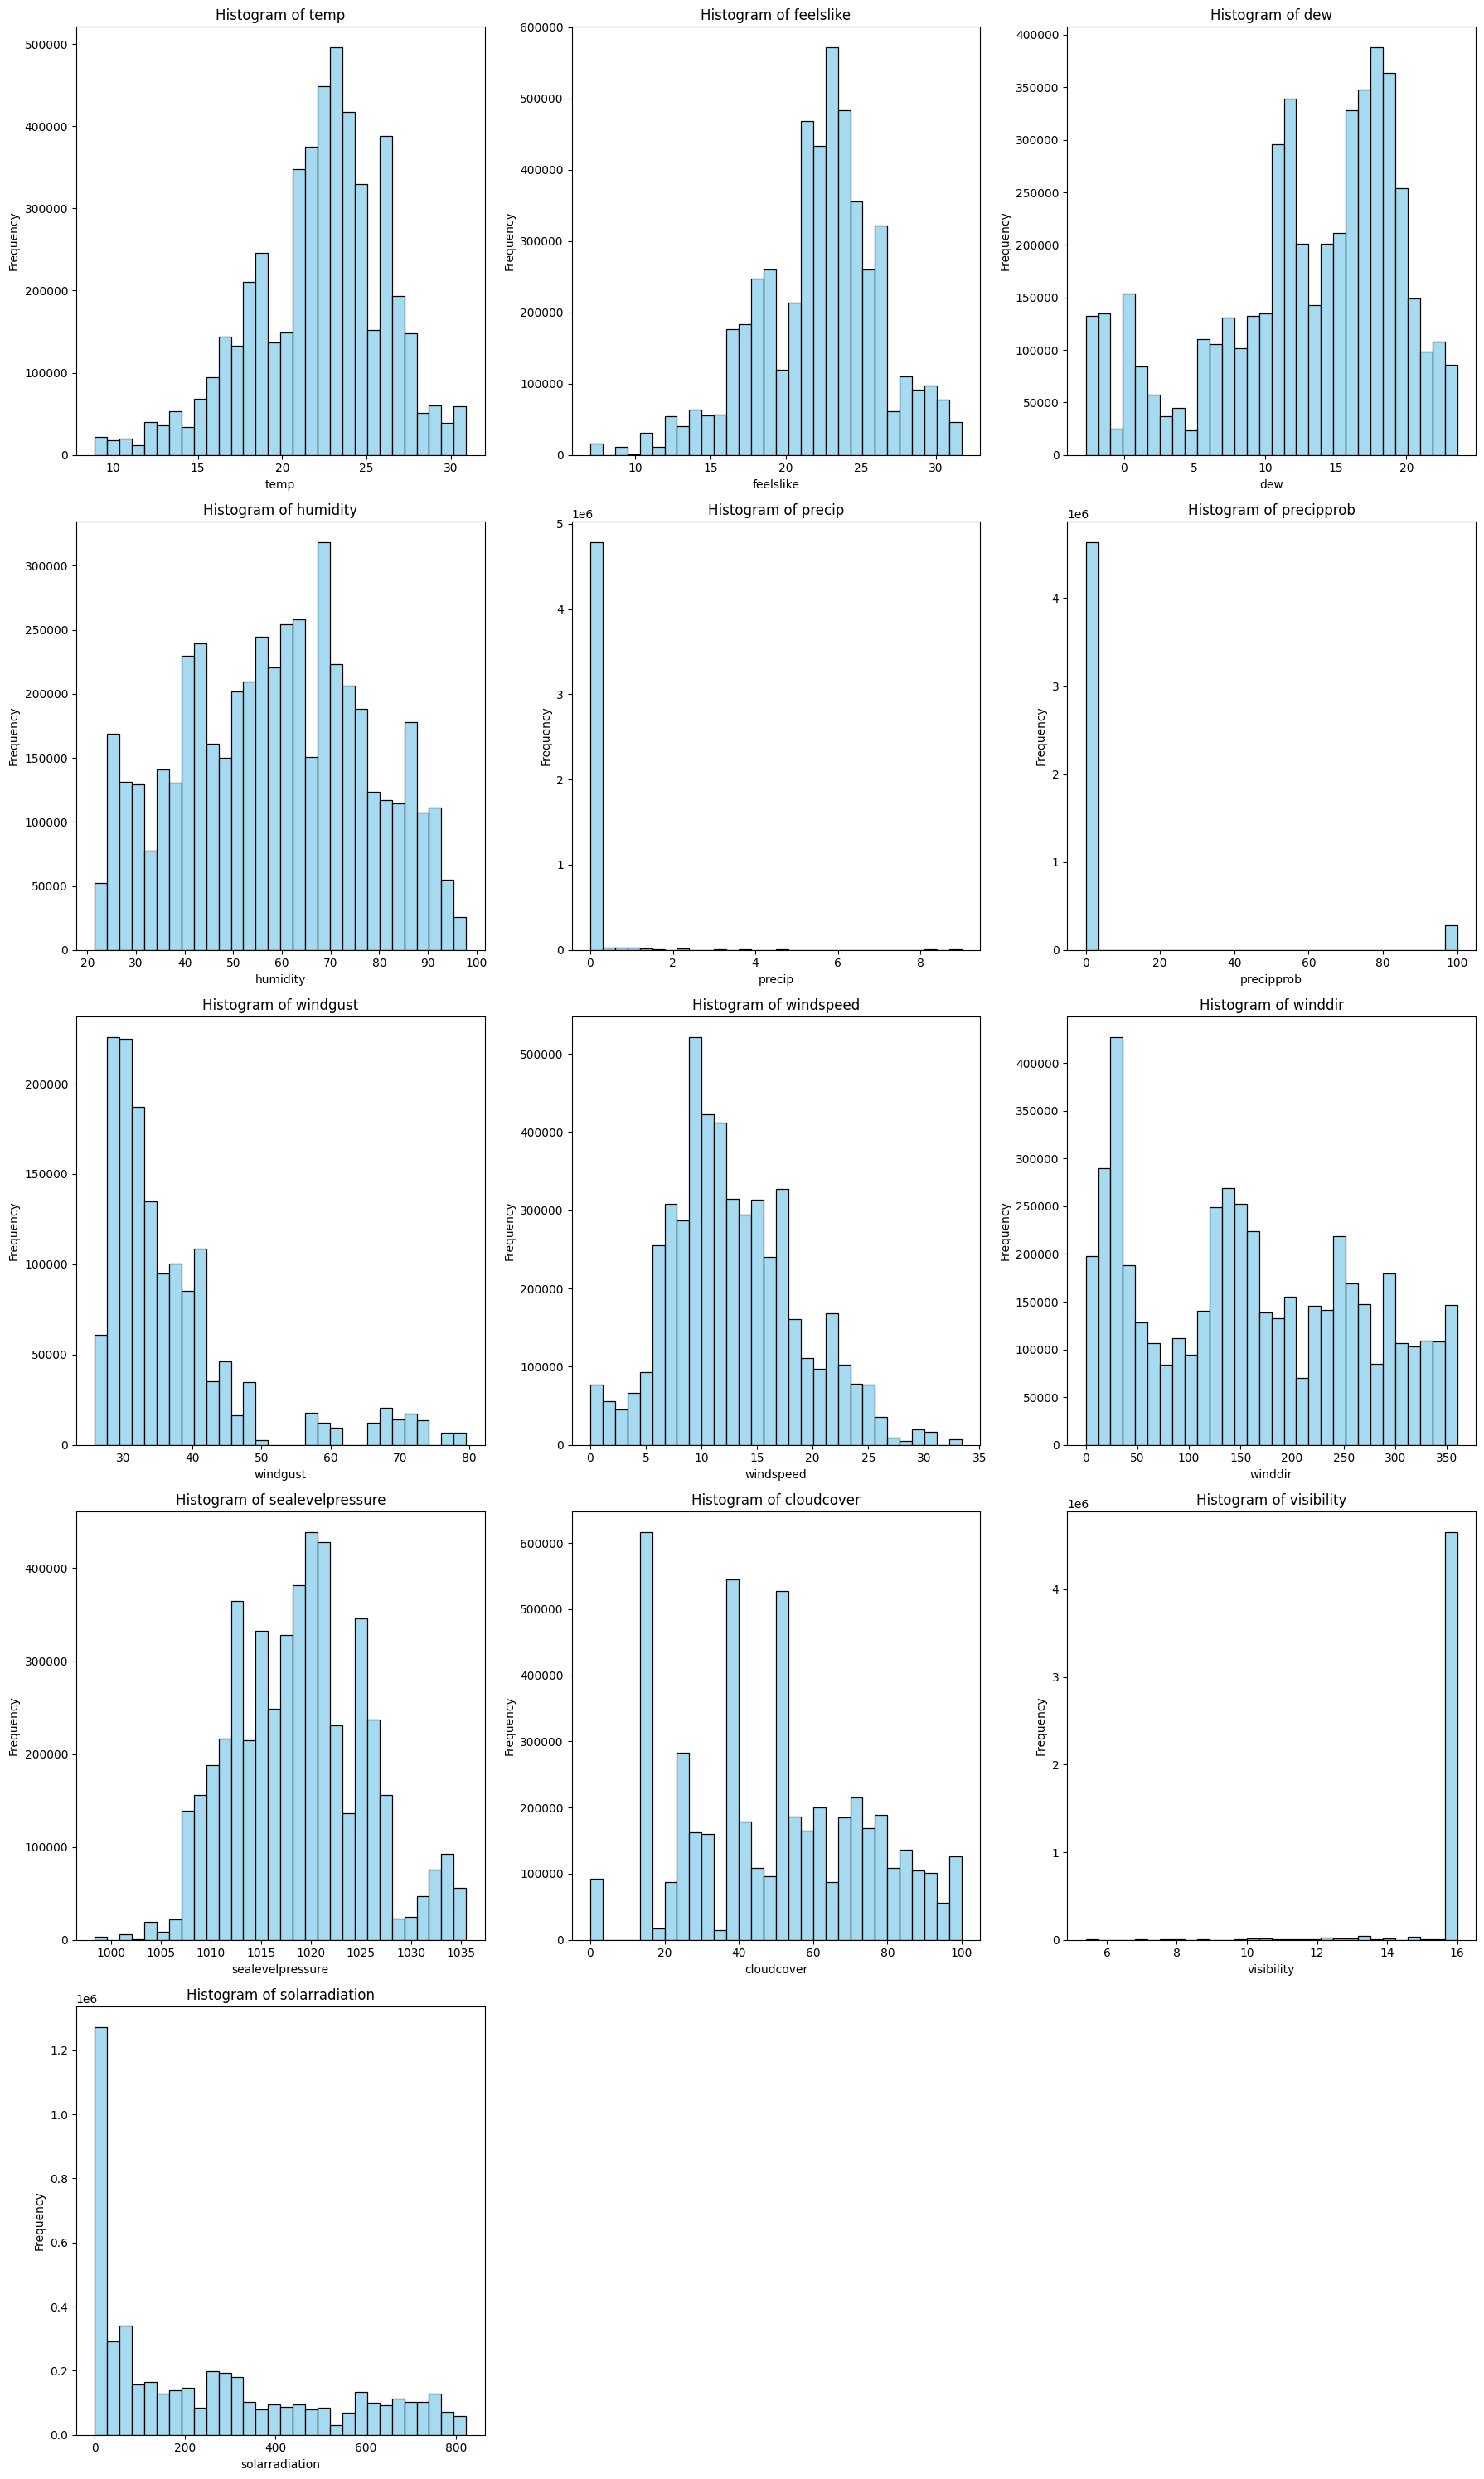

In [ ]:
def plot_quantitative_histogram(column, ax):
    sns.histplot(df[column], bins=30, kde=False, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

columns = df.select_dtypes(include=['float64', 'int64']).columns[2:-2]

num_columns = 3
num_rows = (len(columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, 6 * num_rows))

for i, column in enumerate(columns):
    row = i // num_columns
    col = i % num_columns
    if num_rows > 1:
        ax = axes[row, col]
    else:
        ax = axes[col]
    plot_quantitative_histogram(column, ax)

for i in range(len(columns), num_rows * num_columns):
    row = i // num_columns
    col = i % num_columns
    if num_rows > 1:
        fig.delaxes(axes[row, col])
    else:
        fig.delaxes(axes[col])

plt.tight_layout()
plt.show()

We keep only relevant variables :

- Temperature and feelslike are barely the same.
- Precip has no variability.
- Preciprob has  no variability.
- Visibility has no variability

### Qualitative data

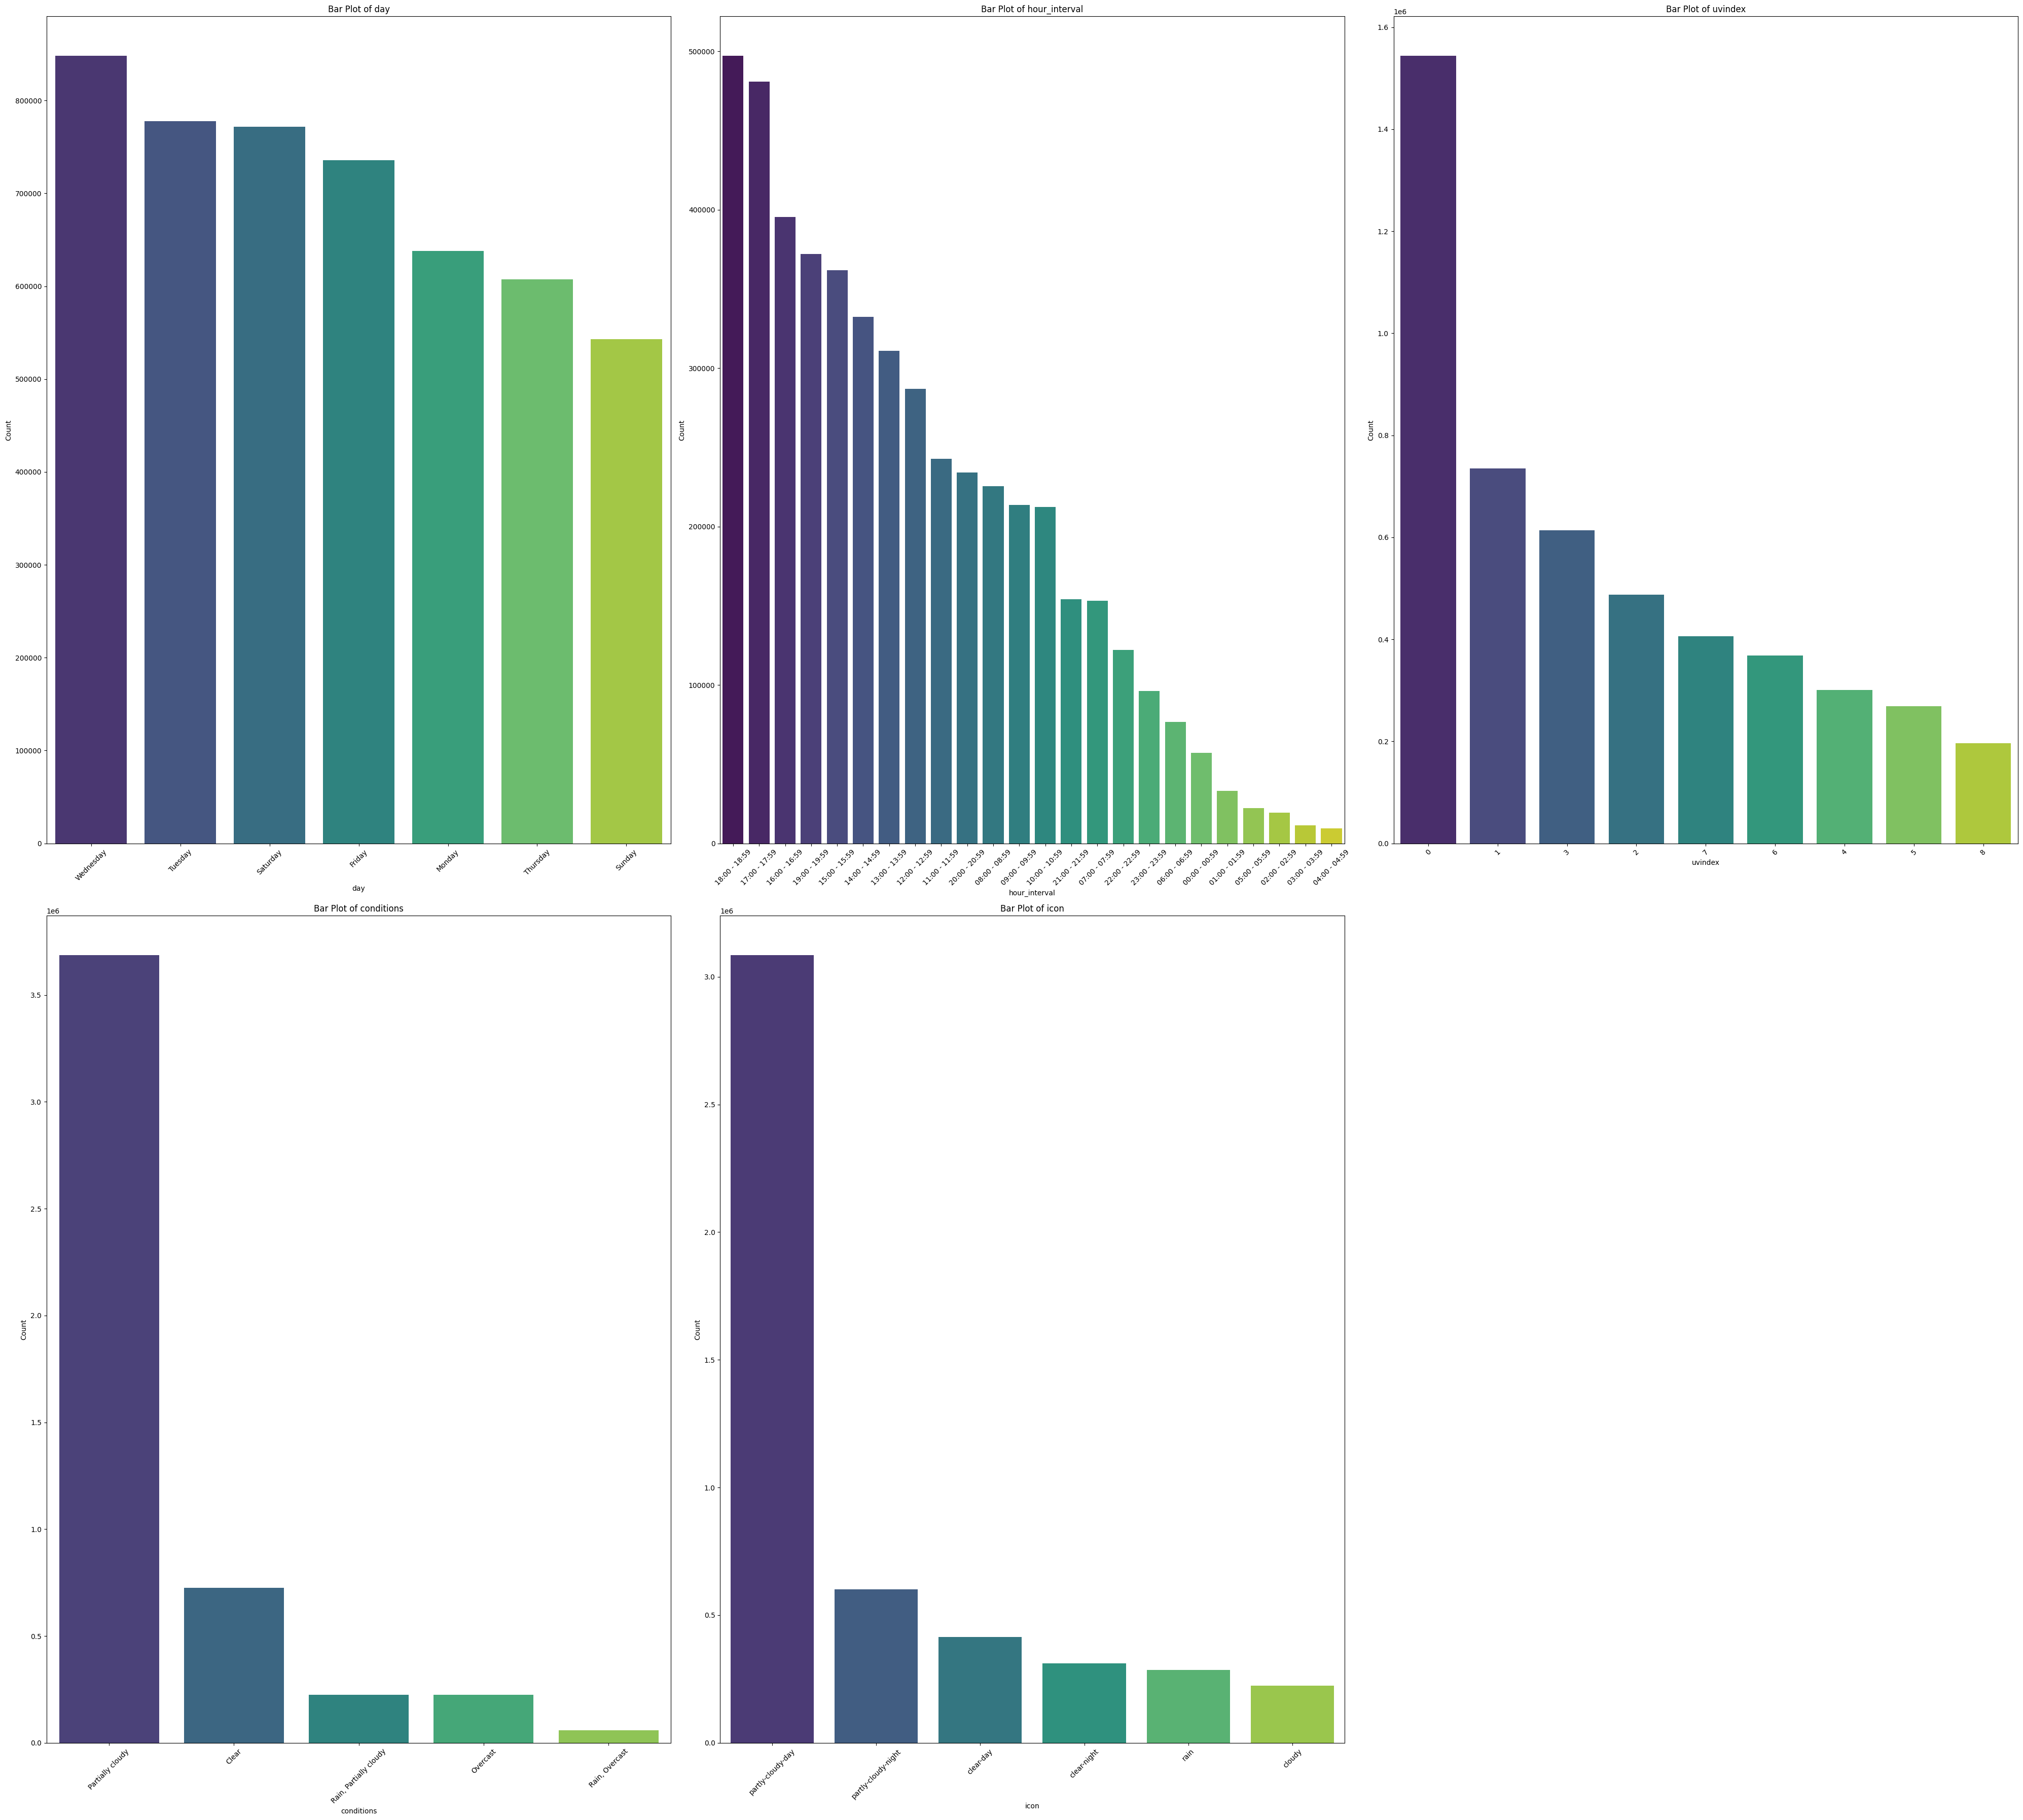

In [ ]:
def plot_categorical_barplot(column, ax):
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts, ax=ax, palette='viridis')
    ax.set_title(f'Bar Plot of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

    if column in ['Year Built', 'Year Remod/Add']:
        n = 4
        ax.set_xticks(ax.get_xticks()[::n])

columns = ['day', 'hour_interval', 'uvindex', 'conditions',\
       'icon']

num_columns = 3
num_rows = (len(columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(40, 6 * (num_rows+4)))

for i, column in enumerate(columns):
    row = i // num_columns
    col = i % num_columns
    if num_rows > 1:
        ax = axes[row, col]
    else:
        ax = axes[col]
    plot_categorical_barplot(column, ax)

for i in range(len(columns), num_rows * num_columns):
    row = i // num_columns
    col = i % num_columns
    if num_rows > 1:
        fig.delaxes(axes[row, col])
    else:
        fig.delaxes(axes[col])

plt.tight_layout()
plt.show()


In [ ]:
columns_to_drop =['temp','precip','precipprob','winddir','sealevelpressure','visibility','solarradiation','icon','severerisk']
df = df.drop(columns=columns_to_drop,axis=1)

It is interesting to look at the evolution of the number of bike in a station with the evolution of the temperature felt.

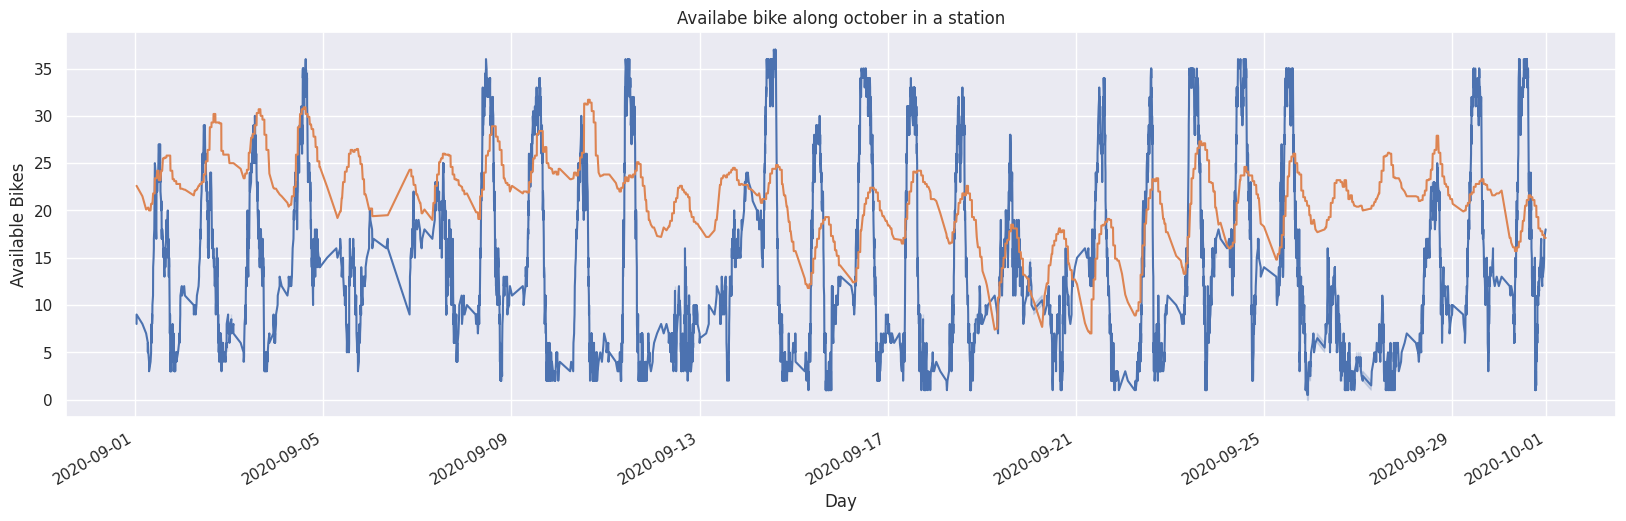

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(20,5))
ax=sns.lineplot(data=df[(df['stationid']==388)] , x='docktime', y='cnt' )
ax=sns.lineplot(data=df[(df['stationid']==388)] , x='docktime', y='feelslike' )
ax.set_xlabel('Day')
ax.set_ylabel('Available Bikes')
plt.xticks(rotation=30, ha='right')
plt.title("Availabe bike along october in a station");


## Bivariate analysis

In [ ]:
df.select_dtypes(include='number').columns

Index(['stationid', 'cnt', 'feelslike', 'dew', 'humidity', 'windgust',
       'windspeed', 'cloudcover', 'count_normalized'],
      dtype='object')

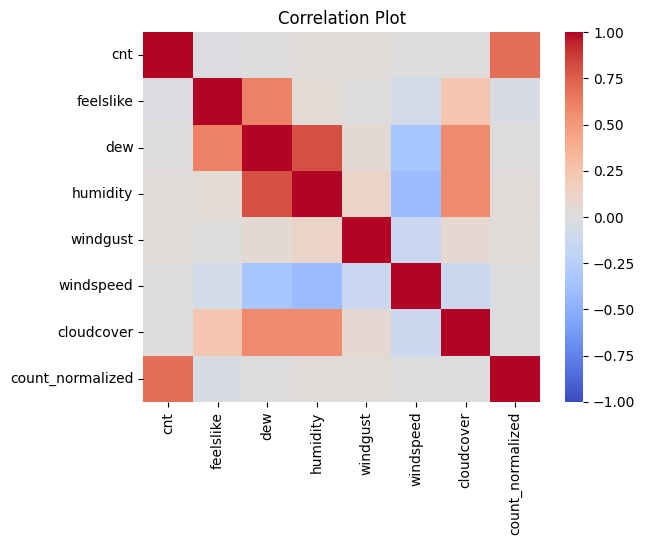

In [ ]:
numerical_columns = numerical_columns[['cnt', 'feelslike', 'dew', 'humidity', 'windgust',\
       'windspeed', 'cloudcover', 'count_normalized']]
correlation_matrix = numerical_columns.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Plot')
plt.show()

Looks like nothing is correlated with cnt and count_normalized.

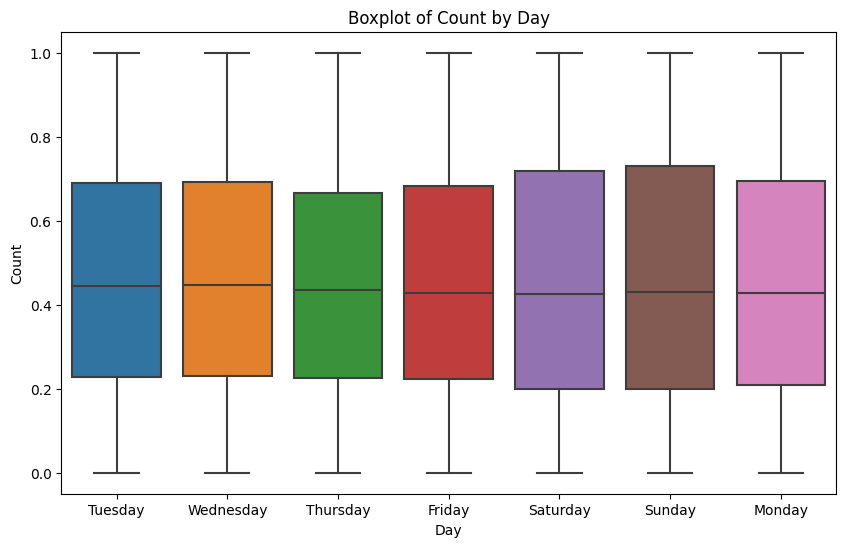

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='day', y='count_normalized', data=df)

plt.title('Boxplot of Count by Day')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()


Distribution are quite similar, it seems like people don't use bike during the week end. Might be that people leave the city during week end.

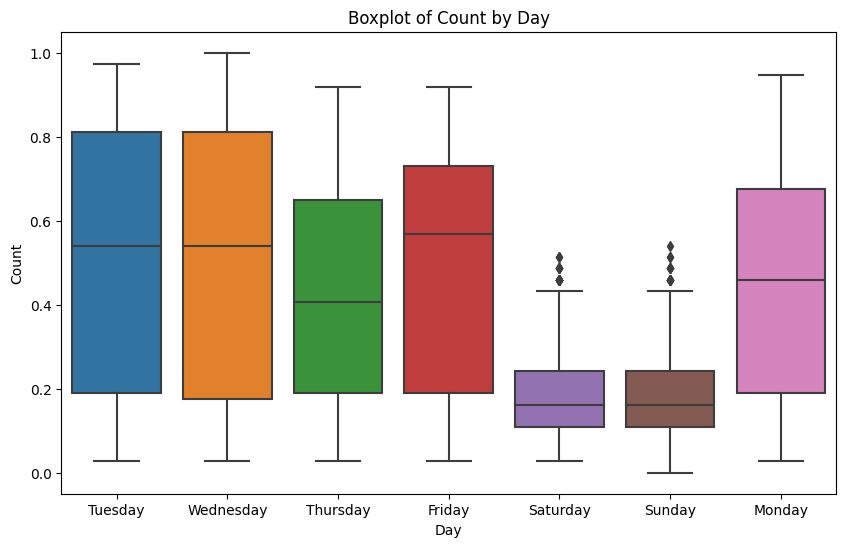

In [ ]:

df_plot_1=df[df['stationid']==493]
plt.figure(figsize=(10, 6))
sns.boxplot(x='day', y='count_normalized', data=df_plot_1)

# Customize the plot
plt.title('Boxplot of Count by Day')
plt.xlabel('Day')
plt.ylabel('Count')

# Show the plot
plt.show()


If we look at a specific station, it seems like people use more bike during the week end since we see less available bike on saturday and sunday.

There is possibly different area in NYC with different behavior. For exemple, might be possible that people near green area uses more bike during week end compared to business area.
This phenomenon will be captured by the station variable in our modelization.

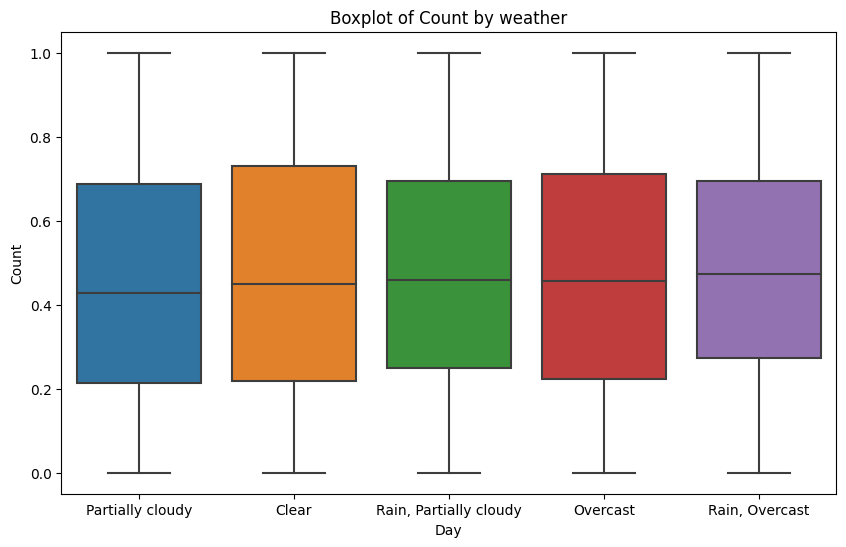

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='conditions', y='count_normalized', data=df)
plt.title('Boxplot of Count by weather')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

It seems like New-Yorkers don't care about rain. There is more bike in station when it rains according to median but it's quite not obvious in the distribution. People still use bikes.

[3534. 4135.]


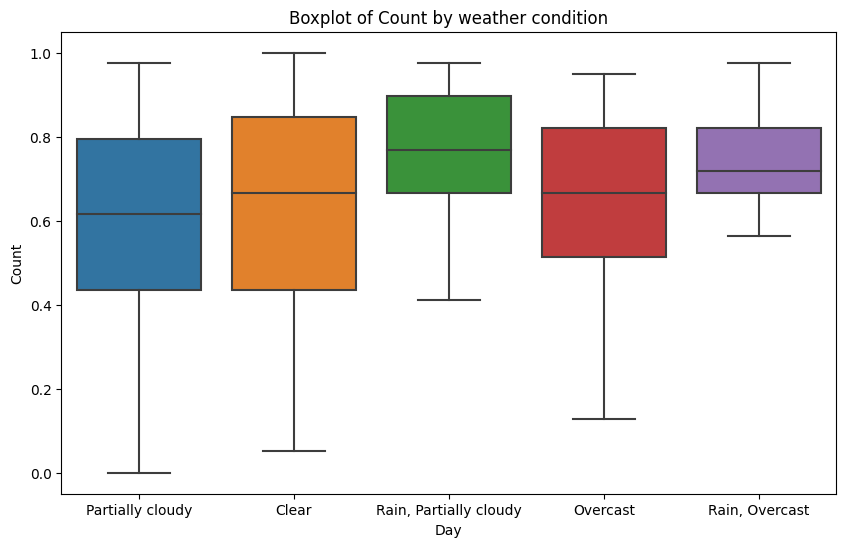

In [ ]:
df_plot_1=df[df['stationid']==3534]
plt.figure(figsize=(10, 6))
sns.boxplot(x='conditions', y='count_normalized', data=df_plot_1)
plt.title('Boxplot of Count by weather condition')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()


In this station, we observe that people prefere not to use bike when it is raining. Might be interesting to create a cross variable between weather and the station.

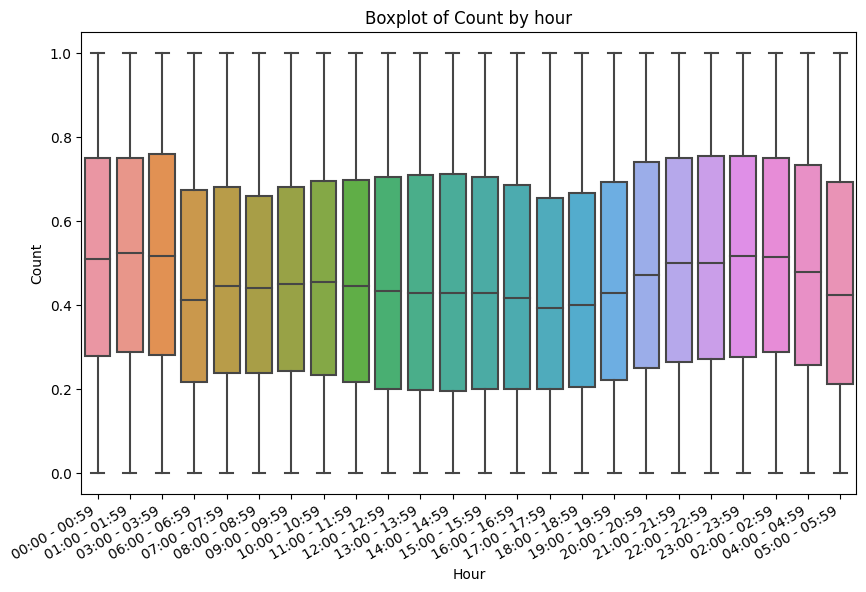

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour_interval', y='count_normalized', data=df)
plt.title('Boxplot of Count by hour')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.show()

Typically, individuals choose to rest during the night, suggesting a preference for biking during the day. However, those who opt for biking at night often do so for specific events like heading to clubs, bars, and various activities available in NYC. It's important to consider the location, as not all areas may have clubs and bars, but in places where they exist, we may observe increased bike usage during the nighttime. Let's focus on a particular station to delve deeper into these patterns.

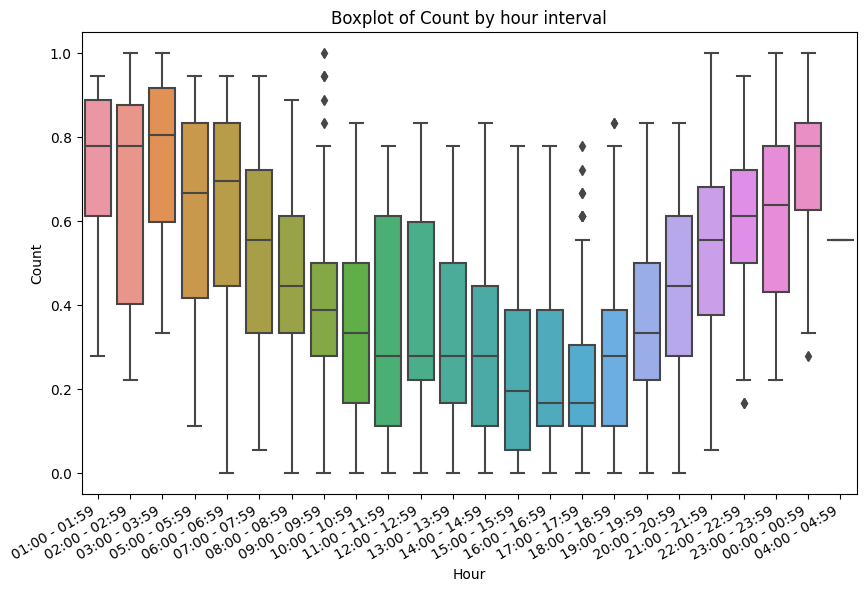

In [ ]:
df_plot_1=df[df['stationid']==3598]
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour_interval', y='count_normalized', data=df_plot_1)
plt.title('Boxplot of Count by hour interval')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.show()


For example this station is highly related to working period.

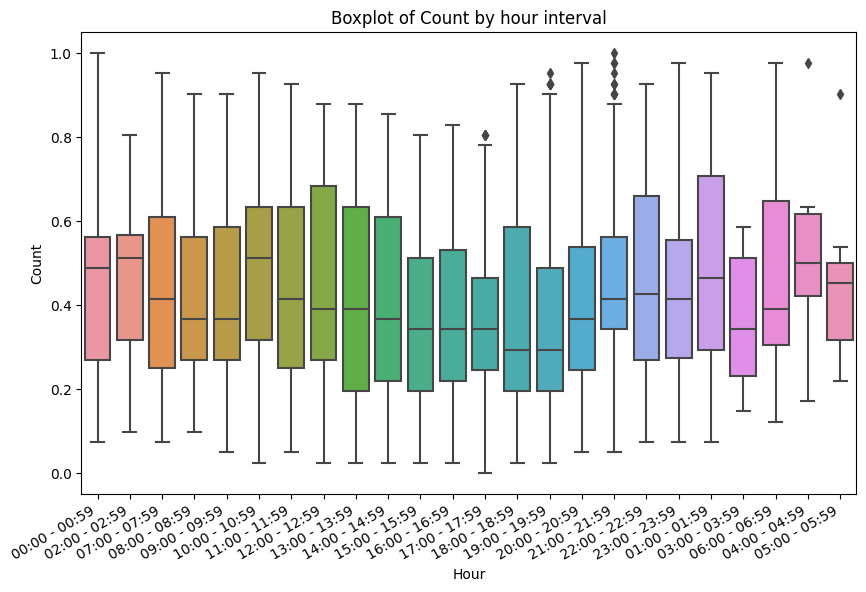

In [ ]:
df_plot_1=df[df['stationid']==3074]
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour_interval', y='count_normalized', data=df_plot_1)
plt.title('Boxplot of Count by hour interval')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.show()


This is not related to anything, could be a station around time square where no one's spleeping. We have to create cross variable.

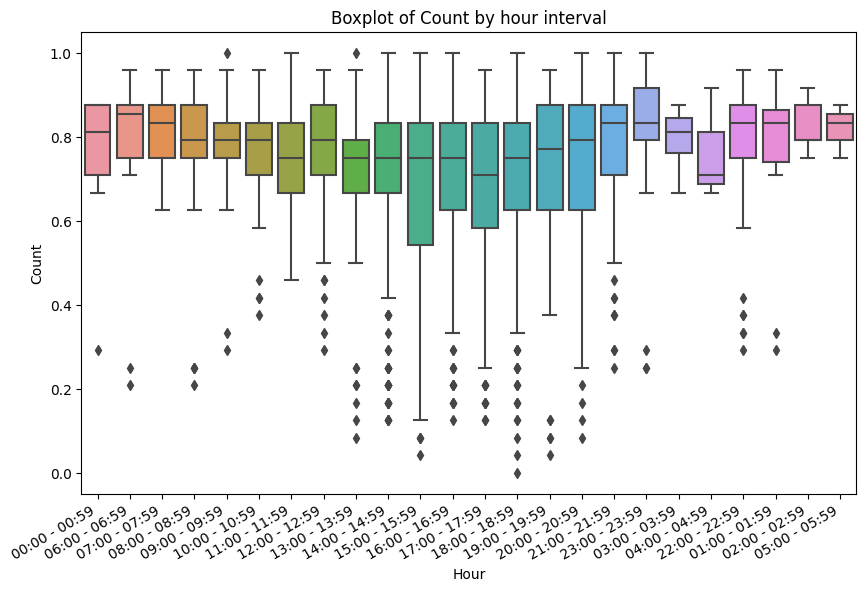

In [ ]:
df_plot_1=df[df['stationid']==3410]
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour_interval', y='count_normalized', data=df_plot_1)
plt.title('Boxplot of Count by hour interval')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.show()


Few people use this station, poor station. Might be located very far from everything.

Now that we have a better understanding of our data, we can move on to the modelisation part.

# Model prediction using LightGBM

In this part we are going to use a LightGBM model in order to predict the number of bikes available in 30 minutes (this has been choosen arbitrarly and can be changed easily).

"LightGBM is a machine learning algorithm that belongs to the family of gradient boosting methods. It is based on decision trees and is used for both classification and regression tasks. What makes LightGBM unique is its high performance and efficiency, achieved through techniques such as leaf-wise tree growth, histogram-based method for data processing, and exclusive feature bundling. It also implements Gradient-based One-Side Sampling (GOSS) to optimize the training process." You can learn more about it [here](https://lightgbm.readthedocs.io/en/stable/index.html).

Basically, it is a pretty powerful tool and we are not even going to use its full potential.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_pickle('/content/drive/MyDrive/Final_db_cnt_station_092020.pkl')
columns_to_drop =['temp','precip','winddir','sealevelpressure','visibility','solarradiation','icon','severerisk','windgust']
df = df.drop(columns=columns_to_drop)
df['docktime']=pd.to_datetime(df['docktime'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The first task of this part was to create the variable *cnt_30min_later*.

To do so, we itterate over all the station, sorting the observations by time.

Then we look at the number of bikes 30 minutes later. But sometimes there were no observations at this moment. So we took the last observation before the 30 minutes, knowing that if there were no observations after then the number of bikes did not change.

In [ ]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore") # For a more readable notebook. Delete this line to see the warnings.

test = df.copy()  # Create a copy to avoid modifying the original DataFrame

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame()

# Iterate through each unique stationid
for station_id in test['stationid'].unique():
    # Subset the DataFrame for the current stationid
    station_subset = test[test['stationid'] == station_id]

    # Sort the DataFrame by 'docktime' within the current station
    station_subset.sort_values('docktime', inplace=True)

    # Create a new column 'docktime_30min_later' with the 'docktime' + 30 minutes
    station_subset['docktime_30min_later'] = station_subset['docktime'] + pd.Timedelta(minutes=30)

    # Convert 'docktime_30min_later' to datetime
    station_subset['docktime_30min_later'] = pd.to_datetime(station_subset['docktime_30min_later'])

    # Merge the DataFrame with itself based on the closest timestamp within 30 minutes
    df_merged = pd.merge_asof(station_subset, station_subset[['docktime', 'cnt']],
                              left_on='docktime_30min_later', right_on='docktime', direction='backward')

    # Rename the 'cnt' column from the merged DataFrame
    df_merged.rename(columns={'cnt_y': 'cnt_30min_later'}, inplace=True)

    # Append the result to the overall result DataFrame
    result_df = pd.concat([result_df, df_merged[['docktime_x', 'cnt_x', 'cnt_30min_later', 'stationid']]])

In [ ]:
result_df

,docktime_x,cnt_x,cnt_30min_later,stationid
0,2020-09-01 00:00:01.043,9.0,9.0,3508.0
1,2020-09-01 00:51:47.340,8.0,9.0,3508.0
2,2020-09-01 01:06:12.936,9.0,9.0,3508.0
3,2020-09-01 01:11:21.730,10.0,9.0,3508.0
4,2020-09-01 01:12:47.369,9.0,9.0,3508.0
...,...,...,...,...
218,2020-09-30 22:43:10.239,7.0,7.0,72.0
219,2020-09-30 22:44:35.258,6.0,7.0,72.0
220,2020-09-30 23:07:16.040,7.0,7.0,72.0
221,2020-09-30 23:53:25.164,8.0,7.0,72.0


The penultimate column seems to be the one we have been looking for after so many hours.

Just by looking at a small sample, the results in it are the ones we wanted.

In [ ]:
# Let's keep the wanted columns and merge them to the original dataset
df_selected_columns = result_df.iloc[:, [0, -2, -1]]
df_selected_columns.rename(columns={'docktime_x': 'docktime'}, inplace=True)
df_merged = pd.merge(df, df_selected_columns[['docktime', 'stationid', 'cnt_30min_later']],
                    on=['docktime', 'stationid'], how='left')
df_merged.head(8)

,docktime,stationid,day,time,hour_interval,cnt,feelslike,dew,humidity,precipprob,windspeed,cloudcover,uvindex,conditions,count_normalized,cnt_30min_later
0,2020-09-01 00:00:01.043,3508.0,Tuesday,00:00:01,00:00 - 00:59,9.0,22.6,16.8,69.53,0.0,9.6,50.4,0,Partially cloudy,0.272727,9.0
1,2020-09-01 00:51:47.340,3508.0,Tuesday,00:51:47,00:00 - 00:59,8.0,22.6,16.8,69.53,0.0,9.6,50.4,0,Partially cloudy,0.242424,9.0
2,2020-09-01 01:06:12.936,3508.0,Tuesday,01:06:12,01:00 - 01:59,9.0,22.6,18.0,75.38,0.0,11.1,17.7,0,Clear,0.272727,9.0
3,2020-09-01 01:11:21.730,3508.0,Tuesday,01:11:21,01:00 - 01:59,10.0,22.6,18.0,75.38,0.0,11.1,17.7,0,Clear,0.303030,9.0
4,2020-09-01 01:12:47.369,3508.0,Tuesday,01:12:47,01:00 - 01:59,9.0,22.6,18.0,75.38,0.0,11.1,17.7,0,Clear,0.272727,9.0
5,2020-09-01 03:34:08.134,3508.0,Tuesday,03:34:08,03:00 - 03:59,10.0,21.5,18.4,82.77,100.0,13.3,70.2,0,"Rain, Partially cloudy",0.303030,10.0
6,2020-09-01 06:03:15.091,3508.0,Tuesday,06:03:15,06:00 - 06:59,11.0,20.3,18.2,87.62,100.0,7.5,78.9,0,"Rain, Partially cloudy",0.333333,11.0
7,2020-09-01 07:42:22.739,3508.0,Tuesday,07:42:22,07:00 - 07:59,10.0,20.0,18.4,90.87,100.0,9.0,69.1,0,"Rain, Partially cloudy",0.303030,9.0


In [ ]:
df = df_merged.copy()
df.sort_values(['stationid', 'docktime'], inplace=True)
df['count_30min_normalized'] = df['cnt_30min_later'] / df.groupby('stationid')['cnt_30min_later'].transform('max')
df['uvindex'] = df['uvindex'].astype(float)

As we have temporal data, a classic train-test split is not a correct idea.

We have to do a time split, taking the past values as a training set until a certain date, and the "future values" as a test set.

We know that we have observations from the first of September 2020 until the 30th of September 2020. We use then 25 first days to predict to next 5 incoming.

In [ ]:
# Filter observations for the first 25 days of September
start_date = '2020-09-01'
end_date_first_25_days = '2020-09-25'
train_set = df[(df['docktime'] >= start_date) & (df['docktime'] <= end_date_first_25_days)]
# Filter observations that occurred after the first 25 days of September
test_set = df[df['docktime'] > end_date_first_25_days]

# The variable we want to predict is the number of bikes in 30 minutes (NOT normalized), according to the date, the hour, the number of bikes at the moment (NOT normalized), and the weather.
X_train = train_set.drop(['docktime','cnt_30min_later','count_30min_normalized','count_normalized','time'],axis=1)
y_train = train_set.loc[:,"cnt_30min_later"]

X_test = test_set.drop(['docktime','cnt_30min_later','count_30min_normalized','count_normalized','time'],axis=1)
y_test = test_set.loc[:,"cnt_30min_later"]

Here is a basic LightGBM model. We do not change any of the default parameters and just use the model as is.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
def getmetrics(y_test,y_pred):
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print("---"*10)
  print("Metrics for the model")
  print("Mean Absolute Error:", mae)
  print("Mean Squared Error:", mse)
  print("R-squared:", r2)
  print("---"*10)

cat_variables = ['day','hour_interval','conditions','stationid']
for feature in cat_variables:
    X_train[feature] = X_train[feature].astype('category')
    X_test[feature] = X_test[feature].astype('category')

# Create the LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train)

# Train the model
params = {
    'objective': 'regression_l1', #regression_l1, L1 loss, aliases: l1, mean_absolute_error, mae
    'max_bin': 1071, # because there are 1070 stationID (we had a warning message)
    'importance_type': 'gain' # for future feature importance as we have a lot of categorical variables
}
model1 = lgb.train(params, lgb_train, num_boost_round=100)

import numpy as np
# Make predictions
y_pred = model1.predict(X_test)
y_pred = np.round(y_pred) # Let's round the results, there is no 'half-bike'


# Evaluate the model
getmetrics(y_test, y_pred)

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.439385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2601
[LightGBM] [Info] Number of data points in the train set: 4021868, number of used features: 12
[LightGBM] [Info] Start training from score 16.000000
------------------------------
Metrics for the model
Mean Absolute Error: 2.4103356651455616
Mean Squared Error: 12.162950291484439
R-squared: 0.9505613034239891
------------------------------


The mean absolute error we obtain is actually quite good.

It seems that, in average, our model predicts the number of bikes in 30 minutes with an error of more or less 2.4 bikes (let's say 3 bikes).

## Hyperparameters tuning
Let's try now to change the hyperparameters.

We can change the number of leaves, the depth of the trees etc.

In [ ]:
# Train the model
params = {
    'objective': 'regression_l1', #regression_l1, L1 loss, aliases: l1, mean_absolute_error, mae
    'max_bin': 1071, # because there are 1070 stationID (we had a warning message)
    'num_leaves': 2 ** 7,
    'n_estimators': 500,
    'learning_rate': 0.2
}
model2 = lgb.train(params, lgb_train, num_boost_round=100)

# Make predictions
y_pred2 = model2.predict(X_test)
y_pred2 = np.round(y_pred2) # Let's round the results, there is no 'half-bike'


# Evaluate the model
getmetrics(y_test, y_pred2)

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2601
[LightGBM] [Info] Number of data points in the train set: 4021868, number of used features: 12
[LightGBM] [Info] Start training from score 16.000000
------------------------------
Metrics for the model
Mean Absolute Error: 2.4289895301029714
Mean Squared Error: 11.83539222005675
R-squared: 0.9518927274384139
------------------------------


This does not improve the MAE (on the contrary, it is worse), and increases the computational time.

Hence for the rest of the modelling we will use the model with the default parameters.

## Feature importance

 Let's look at the features' importance for our model.

In [ ]:
feature_importance = pd.Series(model1.feature_importance(), index=X_train.columns)
feature_importance_sorted = feature_importance.sort_values(ascending=False).apply(lambda x: '{:.2f}'.format(x))

In [ ]:
feature_importance_sorted

stationid        1773.00
hour_interval     612.00
cnt               549.00
day                28.00
uvindex            21.00
feelslike          10.00
cloudcover          4.00
dew                 3.00
humidity            0.00
precipprob          0.00
windspeed           0.00
conditions          0.00
dtype: object

We see here that the most important features are the ID of the station, the hour interval we are in and the number of bikes there is at the moment.


## Quantiles and prediction intervals

This part is about finding prediction intervals for our model in order to see if the true value is "most of the time" in this interval or not.

In [ ]:
quantiles = [0.05, 0.5, 0.95]
y_predQ = pd.DataFrame(index=X_test.index, columns=quantiles)

for q in quantiles:
    # Train the model
    params = {
    'objective': 'quantile',
    'alpha': q,
    'max_bin': 1071, # because there have 1070 stationID (we had a warning message)
    }
    modelQ = lgb.train(params, lgb_train, num_boost_round=100)
    y_predQ[q] = modelQ.predict(X_test)

print("---"*10)
in_ci = ((y_predQ[0.05] <= y_test) & (y_test <= y_predQ[0.95])).mean()
print(f'{in_ci:.2%}')

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2601
[LightGBM] [Info] Number of data points in the train set: 4021868, number of used features: 12
[LightGBM] [Info] Start training from score 2.000000
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.225970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2601
[LightGBM] [Info] Number of data points in the train set: 4021868, number of used features: 12
[LightGBM] [Info] Start training from score 16.000000
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Inf

This result means that in average, the prediction interval contains the true value 86.85% of the time. Which is a decent result.

# Model prediction using LightGBM and dummy variables

In this part, we will see what can add to the model the creation of dummies for the categorical variables.

In [ ]:
# We repeat the same code as before because we had sometimes problems with the RAM. So it was simpler to just re run an entire cell instead of finding them and re running them one by one
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_pickle('/content/drive/MyDrive/Final_db_cnt_station_092020.pkl')
columns_to_drop =['temp','precip','winddir','sealevelpressure','visibility','solarradiation','icon','severerisk','windgust']
df = df.drop(columns=columns_to_drop)
df['docktime']=pd.to_datetime(df['docktime'])
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore") # For a more readable notebook. Delete this line to see the warnings.

test = df.copy()  # Create a copy to avoid modifying the original DataFrame

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame()

# Iterate through each unique stationid
for station_id in test['stationid'].unique():
    # Subset the DataFrame for the current stationid
    station_subset = test[test['stationid'] == station_id]

    # Sort the DataFrame by 'docktime' within the current station
    station_subset.sort_values('docktime', inplace=True)

    # Create a new column 'docktime_30min_later' with the 'docktime' + 30 minutes
    station_subset['docktime_30min_later'] = station_subset['docktime'] + pd.Timedelta(minutes=30)

    # Convert 'docktime_30min_later' to datetime
    station_subset['docktime_30min_later'] = pd.to_datetime(station_subset['docktime_30min_later'])

    # Merge the DataFrame with itself based on the closest timestamp within 30 minutes
    df_merged = pd.merge_asof(station_subset, station_subset[['docktime', 'cnt']],
                              left_on='docktime_30min_later', right_on='docktime', direction='backward')

    # Rename the 'cnt' column from the merged DataFrame
    df_merged.rename(columns={'cnt_y': 'cnt_30min_later'}, inplace=True)

    # Append the result to the overall result DataFrame
    result_df = pd.concat([result_df, df_merged[['docktime_x', 'cnt_x', 'cnt_30min_later', 'stationid']]])

# Let's keep the wanted columns and merge them to the original dataset
df_selected_columns = result_df.iloc[:, [0, -2, -1]]
df_selected_columns.rename(columns={'docktime_x': 'docktime'}, inplace=True)
df_merged = pd.merge(df, df_selected_columns[['docktime', 'stationid', 'cnt_30min_later']],
                    on=['docktime', 'stationid'], how='left')
df_merged.head(8)
df = df_merged.copy()
df.sort_values(['stationid', 'docktime'], inplace=True)
df['count_30min_normalized'] = df['cnt_30min_later'] / df.groupby('stationid')['cnt_30min_later'].transform('max')
df['uvindex'] = df['uvindex'].astype(float)

df_day_dummies = pd.get_dummies(df["day"],dtype=int)

df['hour_interval'] = df['hour_interval'].str.replace('[^a-zA-Z0-9]', '_')
df_Hinterval_dummies = pd.get_dummies(df["hour_interval"],dtype=int)

df['conditions'] = df['conditions'].str.replace('[^a-zA-Z0-9]', '_')
df_conditions_dummies = pd.get_dummies(df["conditions"],dtype=int)

df_and_dummies = pd.concat([df, df_day_dummies,df_Hinterval_dummies,df_conditions_dummies], axis=1)
df_and_dummies = df_and_dummies.drop(['day',"hour_interval","conditions",'time'],axis=1)

df_and_dummies.to_csv('/content/drive/MyDrive/df_and_dummies.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Here we import the previous dataset created
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df_and_dummies = pd.read_csv('/content/drive/MyDrive/df_and_dummies.csv')

# Filter observations for the first 25 days of September
start_date = '2020-09-01'
end_date_first_25_days = '2020-09-25'
train_setD = df_and_dummies[(df_and_dummies['docktime'] >= start_date) & (df_and_dummies['docktime'] <= end_date_first_25_days)]
# Filter observations that occurred after the first 25 days of September
test_setD = df_and_dummies[df_and_dummies['docktime'] > end_date_first_25_days]

# The variable we want to predict is the number of bikes in 30 minutes (NOT normalized), according to the date, the hour, the number of bikes at the moment (NOT normalized), and the weather.
X_trainD = train_setD.drop(['docktime','cnt_30min_later','count_30min_normalized','count_normalized'],axis=1)
y_trainD = train_setD.loc[:,"cnt_30min_later"]

X_testD = test_setD.drop(['docktime','cnt_30min_later','count_30min_normalized','count_normalized'],axis=1)
y_testD = test_setD.loc[:,"cnt_30min_later"]
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

modelD = lgb.LGBMRegressor(
    objective='regression_l1',
    max_bin= 1071, # because there are 1070 stationID (we had a warning message)
    importance_type= 'gain' # for future feature importance as we have a lot of categorical variables
)

modelD = modelD.fit(X_trainD, y_trainD)

import numpy as np
# Make predictions
y_predD = modelD.predict(X_testD)
y_predD = np.round(y_predD) # Let's round the results, there is no 'half-bike'

def getmetrics(y_test,y_pred):
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print("---"*10)
  print("Metrics for the model")
  print("Mean Absolute Error:", mae)
  print("Mean Squared Error:", mse)
  print("R-squared:", r2)
  print("---"*10)
# Evaluate the model
getmetrics(y_testD, y_predD)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.545192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 4021868, number of used features: 45
[LightGBM] [Info] Start training from score 16.000000
------------------------------
Metrics for the model
Mean Absolute Error: 2.5284663675086696
Mean Squared Error: 13.92275970879086
R-squared: 0.943408212954259
------------------------------


### Feature importance

In [ ]:
pd.Series(modelD.feature_importances_, index=X_trainD.columns).sort_values(ascending=False)

cnt                       4.397859e+07
stationid                 7.905052e+05
uvindex                   3.640968e+05
19_00___19_59             1.138757e+05
18_00___18_59             8.635711e+04
17_00___17_59             7.948321e+04
feelslike                 6.724625e+04
16_00___16_59             3.823451e+04
07_00___07_59             3.451336e+04
humidity                  2.411925e+04
06_00___06_59             1.070255e+04
09_00___09_59             6.519614e+03
dew                       3.444950e+03
08_00___08_59             3.357099e+03
10_00___10_59             3.339078e+03
20_00___20_59             3.300981e+03
windspeed                 3.293739e+03
11_00___11_59             2.059206e+03
cloudcover                1.874901e+03
15_00___15_59             1.604872e+03
05_00___05_59             1.405610e+03
Saturday                  1.071060e+03
Sunday                    4.704910e+02
Tuesday                   4.011570e+02
Rain__Overcast            3.602654e+02
22_00___22_59            

In conclusion, the creation of those dummy variables does not help in the prediction (we even get a bigger MAE).

But it helps knowing the importance of each category of the categorical variables. Again, the number of bikes available et the station ID are the most important features in the prediction of the future number of bikes available.

# Prediction

The following graph shows us that the predicted number of bikes is not randomly selected, and is not too far from the real number of bikes (without being perfect).

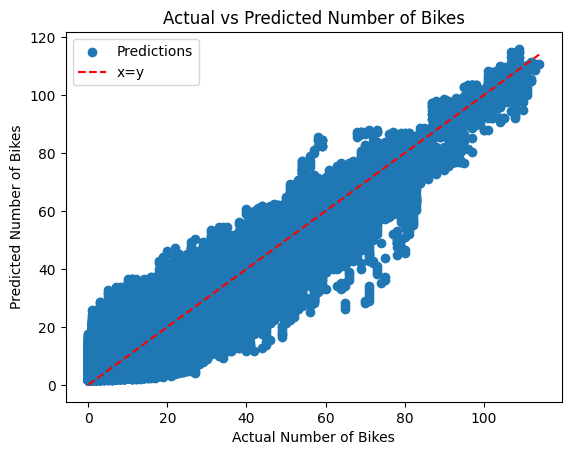

In [ ]:
import matplotlib.pyplot as plt


plt.scatter(y_test, y_pred, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='x=y')
plt.xlabel("Actual Number of Bikes")
plt.ylabel("Predicted Number of Bikes")
plt.title("Actual vs Predicted Number of Bikes")
plt.legend()
plt.show()


If we take a small sample of our data we can see that most of the *y_pred* points are close to the *y_test* points (most of the points are located near the y=x line).

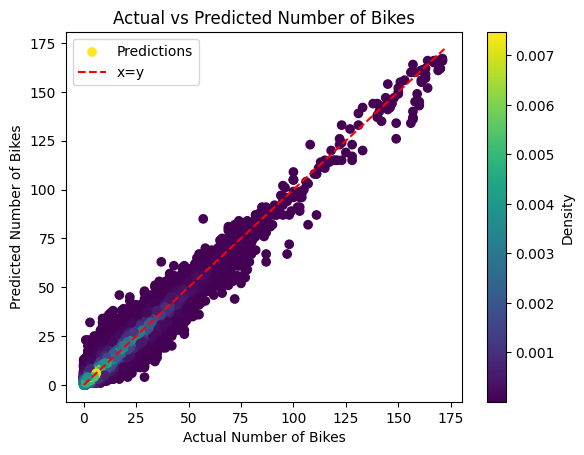

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

sample_size = 50000  # because we have more then 1 000 000 observations, so computing the density is quite long

# Calculating the density with the selected sample
indices = np.random.choice(len(y_test), size=sample_size, replace=False)
indices = indices[indices < len(y_test)]
xy = np.vstack([y_test.iloc[indices], y_pred[indices]])
z = gaussian_kde(xy)(xy)

# Scatter plot
plt.scatter(y_test.iloc[indices], y_pred[indices], c=z, cmap='viridis', label='Predictions')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='x=y')
plt.xlabel("Actual Number of Bikes")
plt.ylabel("Predicted Number of Bikes")
plt.title("Actual vs Predicted Number of Bikes")
plt.legend()
plt.colorbar(label='Density')
plt.show()


We can use our model with a random observation.

Let's say we are on a partially cloudy Monday, it is 1pm and there is 0 bikes at the station 82 (let's not bother with choosing one by one specific weather variables, let's do it randomly). Then we can hope that there will be 1 bike in 30 minutes.

In [ ]:
# Create a new observation quite randomly first
new_observation = pd.DataFrame({
    'stationid': [82.0],
    'day': ['Monday'],
    'hour_interval': ['13:00 - 13:59'],
    'cnt': [0],
    'feelslike': [np.random.uniform(0, 100)],
    'dew': [np.random.uniform(0, 100)],
    'humidity': [np.random.uniform(0, 100)],
    'precipprob': [np.random.uniform(0, 1)],
    'windspeed': [np.random.uniform(0, 10)],
    'cloudcover': [np.random.uniform(0, 100)],
    'uvindex': [np.random.uniform(0, 10)],
    'conditions': ['Partially cloudy']
})

# Like before, make sure the categorical variables have the good type
cat_variables = ['day','hour_interval','conditions','stationid']
for feature in cat_variables:
    new_observation[feature] = new_observation[feature].astype('category')

# Make predictions using the trained model
predicted_cnt_30min_later = model1.predict(new_observation)

# Display the predicted count
print("Predicted number of bikes in 30 minutes:", np.round(predicted_cnt_30min_later[0]))


Predicted number of bikes in 30 minutes: 1.0
